### Классификация пассажиров на входящих и выходящих (работа с изображениями)

Задача: классификация пассажиров на входящих и выходящих на основе изображений с камер видеонаблюдения. Добиться точности классификации не менее 90%.

Импорт библиотек

In [41]:
# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

# для работы с архивами
import zipfile

Загрузка данных

In [42]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
# https://storage.yandexcloud.net/algorithmic-datasets/bus.zip
gdown.download('https://storage.yandexcloud.net/algorithmic-datasets/bus.zip', 'datas/bus/bus.zip', quiet=True)

# Распакуем архив в директорию /datas/bus
with zipfile.ZipFile('datas/bus/bus.zip', 'r') as zip_ref:
    zip_ref.extractall('datas/bus')
    zip_ref.close()

os.remove('datas/bus/bus.zip')

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = 'datas/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Входящий', 'Выходящий']

Определеяем имена

In [43]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


Имена классов

In [ ]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Пример изображений

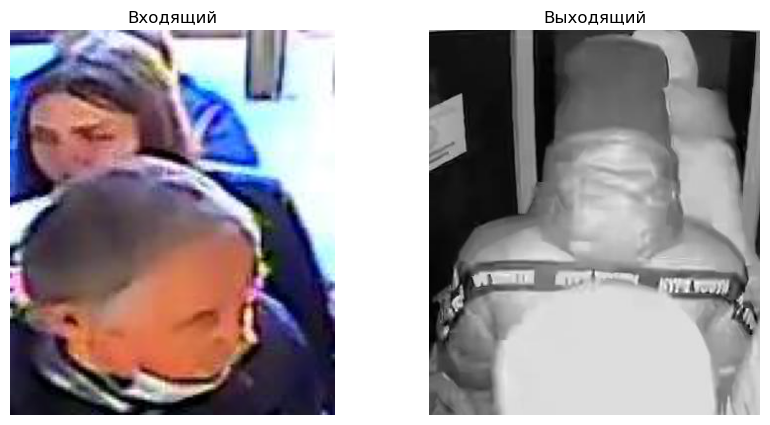

In [45]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

Подготовка данных

In [46]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


### Построение сверточной нейронной сети с требуемой точностью 90%

Определим характеристики исходных изображений

Каналы:

In [47]:
channels = {}
for img_path in data_files:
    img = Image.open(img_path)
    channels[img.mode] = channels.get(img.mode, 0) + 1

channels

{'RGB': 9081}

Размеры:

In [ ]:
sizes = {}
for img_path in data_files:
    img = Image.open(img_path)
    sizes[img.size] = sizes.get(img.size, 0) + 1

sizes

### Изображения
- 3 канала
- Все размеры уникальны

### Подготовка данных

Унификация размеров изображений и преобразование в массивы

In [49]:
IMG_SIZE = (64, 64)

# Создание пустого массива для изображений
X = np.zeros((len(data_files), *IMG_SIZE, 3))


for i, img_path in enumerate(data_files):
    img = Image.open(img_path)
    img = img.resize(IMG_SIZE)
    X[i] = np.array(img) / 255

y = np.array(data_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
print(f'Размерность обучающей выборки: {X_train.shape},\n'
      f'Размерность тестовой выборки: {X_test.shape},\n'
      f'Размерность обучающей выборки меток: {y_train.shape},\n'
      f'Размерность тестовой выборки меток: {y_test.shape}')

print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Размерность обучающей выборки: (7264, 64, 64, 3),
Размерность тестовой выборки: (1817, 64, 64, 3),
Размерность обучающей выборки меток: (7264,),
Размерность тестовой выборки меток: (1817,)
Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


Построение модели

In [51]:
input_shape = X_train.shape[1:]

model = Sequential()

# Входной сверточный слой. 64x64x3 -> 32x32x16
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.3))


In [52]:
# Второй сверточный слой. 32x32x16 -> 16x16x32
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.3))

In [53]:
# Третий сверточный слой. 16x16x32 -> 8x8x64
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

In [54]:
# Четвертый сверточный слой. 8x8x64 -> 4x4x128
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

In [55]:
# Пятый сверточный слой. 4x4x128 -> 2x2x256
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

In [56]:
# Слой преобразования из двумерного вида в плоский. 2x2x256 -> 1 024
model.add(Flatten())

In [57]:
# Полносвязные слои
model.add(Dense(512, activation='elu')) # 1024*512=524 288
model.add(BatchNormalization())

model.add(Dense(256, activation='elu')) # 512*256=131 072
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='elu')) # 256*128=32 768
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='elu')) # 128*64=8 192
model.add(BatchNormalization())

# Выходной полносвязный слой
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 spatial_dropout2d (SpatialD  (None, 32, 32, 16)       0         
 ropout2D)                                                       
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        4640      
                                                      

Обучение модели

In [58]:
start_time = time.time()

history = model.fit(X_train, y_train, epochs=128, batch_size=512, validation_split=0.2, shuffle=True, verbose=0)

print(f'Время обучения: {time.time() - start_time:.2f} секунд')

Время обучения: 897.06 секунд


Оценка модели

57/57 [==============================] - 1s 15ms/step - loss: 0.0560 - accuracy: 0.9846


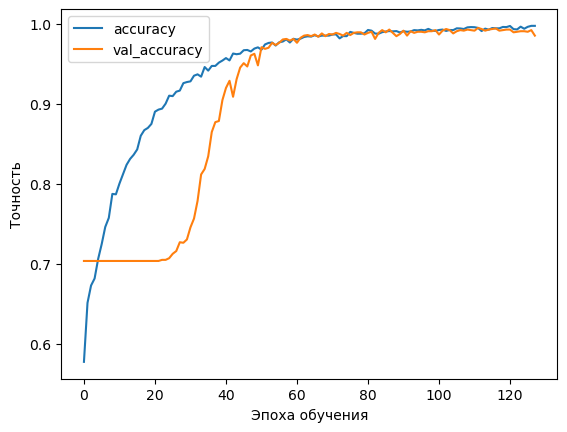

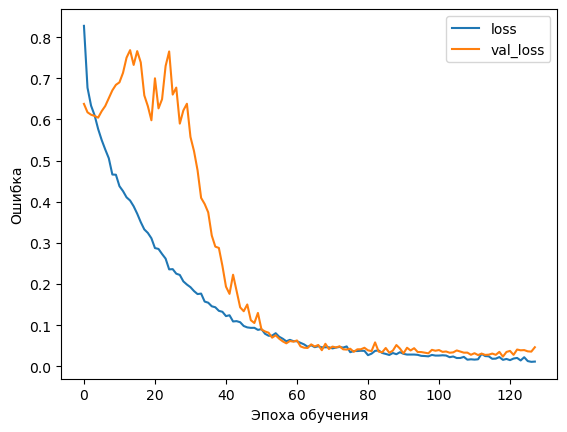

57/57 [==============================] - 1s 16ms/step - loss: 0.0560 - accuracy: 0.9846
Точность на тестовой выборке: 98.46%


In [59]:
model.evaluate(X_test, y_test)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

print(f'Точность на тестовой выборке: {model.evaluate(X_test, y_test)[1] * 100:.2f}%')

### Вывод!

Сверточные слои:
- Количество сверточных слоев: `5`
- Количество фильтров в сверточных слоях: `16`, `32`, `64`, `128`, `256`
- Dropout: 0.3, применяется к полносвязным слоям (перед вторым и третьим слоями)
- BatchNormalization применяется к каждому сверточному и полносвязному слою
- Пулинг: 2x2, применяется после каждого сверточного слоя

Полносвязные слои:
- Полносвязные слои: `4`
- Количество нейронов в полносвязных слоях: `512`, `256`, `128`, `64`
- Dropout: 0.3, применяется к полносвязным слоям (перед третьим и четвертым слоями)
- BatchNormalization применяется к каждому полносвязному слою

Гиперпараметры и результаты:
- Количество эпох обучения: `128`
- Размер батча: `512`
- Оптимизатор: `Adam`, скорость обучения: `0.0001`
- Время обучения: `897.06` секунд или примерно `15` минут
- Точность на тестовой выборке: `98,46`%